<a href="https://colab.research.google.com/github/bjatkin/Pepto-GAN/blob/tune-wgan/Pepto_Tune_GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# All Imports / Options

In [0]:
import pdb
import numpy as np
import random
import csv
from tqdm import tqdm

import matplotlib.pyplot as plt
from scipy.stats.stats import pearsonr

import torchvision.transforms as transforms
from torchvision.utils import save_image

from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable

import torch.nn as nn
import torch.nn.functional as F
import torch

Tensor = torch.cuda.FloatTensor

In [0]:
class Options():
  def __init__(self,
               n_epochs=40,
               amino_acids='CDFGHILNRSVY',
               peptide_length=8,
               latent_dim=100,
               glr=0.001,
               dlr=0.001,
               batch_size=64,
               clip_value=0.01,
               n_critic=5):

    self.n_epochs=n_epochs
    self.amino_acids=amino_acids
    self.peptide_length=peptide_length
    self.latent_dim=latent_dim
    self.glr=glr
    self.dlr=dlr
    self.batch_size=batch_size
    self.clip_value=clip_value
    self.n_critic=n_critic

wgan_opt = Options()

# Utility Functions

In [0]:
def one_hot(peptide):
  encodings = []
  for aa in peptide:
    encoding = torch.zeros(len(wgan_opt.amino_acids))
    index = wgan_opt.amino_acids.index(aa)
    encoding[index] = 1.0
    encodings.append(encoding)
  return torch.stack(encodings)

def one_hot_s(peptides):
  all_encodings = []
  for peptied in peptides:
    all_encodings.append(one_hot(peptied))
  return torch.stack(all_encodings)

def decode_peptide(peptide):
  pep = ""
  for p in peptide:
    i = p.argmax()
    pep = pep + wgan_opt.amino_acids[i]
  
  return pep

def decode_peptide_s(peptides):
  peps = []
  for pep in peptides:
    peps.append(decode_peptide(pep))
  
  return peps

def load_model(model, file_name):
  model.load_state_dict(torch.load(file_name))

# Data Genration

In [70]:
# -------------------
# Generate Base Data
# -------------------

all_sequences = []
all_scores = []
with open('all_data_filtered.csv') as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=",")
    line_count = 0
    for row in csv_reader:
      line_count += 1
      all_sequences.append(row[0])
      all_scores.append(float(row[1]))
    
#This is the base dataset that everything is based on
print("Saving {} Sequences...".format(line_count))
np.save("All_Peptide_Sequences", all_sequences)
np.save("All_Tox_Scores", all_scores)

Saving 105416 Sequences...


In [71]:
# --------------------------------
# Punish Canonical Toxic Peptides
# --------------------------------
def is_canonical_peptide(sequence):
  hydrophobicity = 0
  cysteines = 0
  for aa in sequence:
      if aa in ["F","I","V","L","W"]:
          hydrophobicity = hydrophobicity + 1
      if aa == "C":
          cysteines = cysteines + 1

  return (hydrophobicity > 3 or cysteines > 2)

def punish_cannon_peptides():
    all_sequences = []
    all_scores = []
    with open('all_data_filtered.csv') as csv_file:
        csv_reader = csv.reader(csv_file, delimiter=",")
        line_count = 0
        for row in csv_reader:
          line_count += 1
          all_sequences.append(row[0])
          shift = 0
          if is_canonical_peptide(row[0]):
            shift = 3
          all_scores.append(float(row[1]) + shift)
    
    return all_sequences, all_scores

sequences, scores = punish_cannon_peptides()
print("Saving {} Sequences...".format(line_count))
np.save("All_Peptide_Sequences", sequences)
np.save("All_Peptide_Scores_Punished", scores)

Saving 105416 Sequences...


# Data Loader

In [0]:
class GenericDataloader(Dataset):
    def __init__(self, data, labels, train=True):
      split = len(data)//10
      self.data = data[split:]
      self.labels = labels[split:]

      if not train:
        self.data = data[:split]
        self.labels = labels[:split]
      
      if train == "all":
        self.data = data
        self.labels = labels
      
    def __getitem__(self, index):
      return (self.data[index], self.labels[index])
    
    def __len__(self):
      return len(self.data)

# WGAN

In [0]:
# ---------------------------------------------------
# Define the Washerstein Generator and Descriminator
# ---------------------------------------------------
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        def block(in_feat, out_feat, normalize=True):
            layers = [nn.Linear(in_feat, out_feat)]
            if normalize:
                layers.append(nn.BatchNorm1d(out_feat, 0.8))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        self.model = nn.Sequential(
            *block(wgan_opt.latent_dim, 128, normalize=False),
            *block(128, 256),
            *block(256, 512),
            *block(512, 1024),
            nn.Linear(1024, int(wgan_opt.peptide_length * len(wgan_opt.amino_acids))),
            # nn.Tanh()
        )

    def forward(self, z):
        pep = self.model(z)
        pep = pep.view(pep.size()[0], wgan_opt.peptide_length, len(wgan_opt.amino_acids))
        pep = F.softmax(pep, dim=2)
        return pep

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(int(len(wgan_opt.amino_acids) * wgan_opt.peptide_length), 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1),
        )

    def forward(self, pep):
        pep_flat = pep.view(pep.size(0), -1)
        validity = self.model(pep_flat)

        return validity

# Initialize generator and discriminator
generator = Generator()
generator.cuda()

discriminator = Discriminator()
discriminator.cuda()

# Configure data loader
dataset = GenericDataloader(
    one_hot_s(np.load("All_Peptide_Sequences.npy")),
    np.load("All_Peptide_Scores_Punished.npy"),
    train="all")
dataloader = torch.utils.data.DataLoader(dataset, batch_size=wgan_opt.batch_size, shuffle=True)

# Optimizers
optimizer_G = torch.optim.RMSprop(generator.parameters(), lr=wgan_opt.glr)
optimizer_D = torch.optim.RMSprop(discriminator.parameters(), lr=wgan_opt.dlr)

## Pre-Condition Generators

In [74]:
# Preconditioned DataSet
sequences = np.load("All_Peptide_Sequences.npy")

pre_dataset = GenericDataloader(
    np.random.normal(0, 1, (len(sequences), wgan_opt.latent_dim)),
    one_hot_s(sequences),
    train="all")

batch_size = 10000
pre_dataloader = torch.utils.data.DataLoader(pre_dataset, batch_size=batch_size, shuffle=True)
pre_optimizer = torch.optim.Adam(generator.parameters(), lr=0.0001)#wgan_opt.glr)
loss_fn = nn.L1Loss()

losses = []
epochs = 1000
for epoch in range(epochs):
    avg_loss = []
    for i, (z, peps) in enumerate(pre_dataloader):
        peps = Variable(peps.type(Tensor))
        z = Variable(z.type(Tensor))

        pre_optimizer.zero_grad()

        gen_peps = generator(z)
        loss = torch.sum(torch.abs(gen_peps - peps))
        losses.append(loss.item())
        avg_loss.append(loss.item())
        # pdb.set_trace()
        
        loss.backward()
        
        pre_optimizer.step()

    print("{}/{} loss: {:.4f}".format(epoch+1, epochs, np.mean(avg_loss)))

# Plot loss
plt.plot(losses, label='losses')
plt.title('Losses')
plt.legend()
plt.show()


KeyboardInterrupt: ignored

In [0]:
z = torch.Tensor(pre_dataset[1:5][0])
z = z.cuda()
peptides = generator(z)

for i, pep in enumerate(peptides):
    print("{} == {}".format(decode_peptide(pep), decode_peptide(pre_dataset[i][1])))

VFCVFCCS == CDCHRGFV
FCCCCFCG == SRVSLVNI
FCVCCCVC == RGLVLGHH
FYCCCCGV == CVRGCCGD


In [0]:
# Custom Loss
def custom_loss(y_hat):
  return torch.mean(torch.min(y_hat, dim=2)[0] - torch.max(y_hat, dim=2)[0])

## Train the WGAN

In [77]:
# --------------------------
#  Washerstein GAN Training
# --------------------------

def was_gan_train():
    for epoch in range(wgan_opt.n_epochs):

        for i, (peps, _) in enumerate(dataloader):

            # Configure input
            real_peps = Variable(peps.type(Tensor))

            # ---------------------
            #  Train Discriminator
            # ---------------------

            optimizer_D.zero_grad()

            # Sample noise as generator input
            z = Variable(Tensor(np.random.normal(0, 1, (peps.shape[0], wgan_opt.latent_dim))))

            # Generate a batch of peptides
            gen_peps = generator(z).detach()
            # Adversarial loss
            d_loss = -torch.mean(discriminator(real_peps)) + torch.mean(discriminator(gen_peps))

            d_loss.backward()
            optimizer_D.step()

            # Clip weights of discriminator
            for p in discriminator.parameters():
                p.data.clamp_(-wgan_opt.clip_value, wgan_opt.clip_value)

            # Train the generator every n_critic iterations
            if i % wgan_opt.n_critic == 0:

                # -----------------
                #  Train Generator
                # -----------------

                optimizer_G.zero_grad()

                # Generate a batch of images
                gen_peps = generator(z)
                # Adversarial loss
                g_loss = -torch.mean(discriminator(gen_peps))

                g_loss.backward()
                optimizer_G.step()

        diff = torch.max(gen_peps[0][0]) - torch.min(gen_peps[0][0])
        print("epoch {}/{} d loss {:.4f}, g loss {:.4f}, diff {:.4f}".format(epoch+1, wgan_opt.n_epochs, d_loss.item(), g_loss.item(), diff))

was_gan_train()

epoch 1/40 d loss -0.0566, g loss 0.0214, diff 0.3983
epoch 2/40 d loss -0.0421, g loss 0.0316, diff 0.6394
epoch 3/40 d loss -0.0482, g loss 0.0357, diff 0.9896
epoch 4/40 d loss -0.0166, g loss 0.0305, diff 1.0000
epoch 5/40 d loss -0.0458, g loss 0.0365, diff 0.6369
epoch 6/40 d loss -0.0483, g loss 0.0284, diff 0.9997
epoch 7/40 d loss -0.0331, g loss 0.0261, diff 1.0000
epoch 8/40 d loss -0.0675, g loss 0.0232, diff 0.9969
epoch 9/40 d loss -0.0255, g loss 0.0211, diff 0.9908
epoch 10/40 d loss -0.0316, g loss 0.0306, diff 1.0000
epoch 11/40 d loss -0.0511, g loss 0.0275, diff 0.9635
epoch 12/40 d loss -0.0438, g loss 0.0282, diff 0.9983
epoch 13/40 d loss -0.0413, g loss 0.0243, diff 0.5587
epoch 14/40 d loss -0.0306, g loss 0.0221, diff 1.0000
epoch 15/40 d loss -0.0303, g loss 0.0236, diff 0.5011
epoch 16/40 d loss -0.0292, g loss 0.0155, diff 0.7047
epoch 17/40 d loss -0.0235, g loss 0.0225, diff 0.9999
epoch 18/40 d loss -0.0626, g loss 0.0277, diff 0.9975
epoch 19/40 d loss 

In [0]:
# THIS DOES NOT WORK (Except now it does YA!)

def train_generator():
    for epoch in range(wgan_opt.n_epochs):
        z = Variable(Tensor(np.random.normal(0, 1, (wgan_opt.batch_size, wgan_opt.latent_dim))))

        optimizer_G.zero_grad()

        # Generate a batch of images
        gen_peps = generator(z)

        # Custom Loss
        loss = custom_loss(gen_peps)

        loss.backward()
        optimizer_G.step()
    
        print("{}/{} loss: {:.4f}".format(epoch+1, wgan_opt.n_epochs, loss.item()))

train_generator()

1/300 loss: -0.0066
2/300 loss: -0.0907
3/300 loss: -0.6091
4/300 loss: -0.9160
5/300 loss: -0.9167
6/300 loss: -0.9529
7/300 loss: -0.9608
8/300 loss: -0.9649
9/300 loss: -0.9657
10/300 loss: -0.9645
11/300 loss: -0.9587
12/300 loss: -0.9628
13/300 loss: -0.9601
14/300 loss: -0.9684
15/300 loss: -0.9725
16/300 loss: -0.9695
17/300 loss: -0.9658
18/300 loss: -0.9728
19/300 loss: -0.9765
20/300 loss: -0.9835
21/300 loss: -0.9785
22/300 loss: -0.9793
23/300 loss: -0.9749
24/300 loss: -0.9735
25/300 loss: -0.9774
26/300 loss: -0.9786
27/300 loss: -0.9845
28/300 loss: -0.9792
29/300 loss: -0.9851
30/300 loss: -0.9840
31/300 loss: -0.9852
32/300 loss: -0.9758
33/300 loss: -0.9872
34/300 loss: -0.9847
35/300 loss: -0.9798
36/300 loss: -0.9859
37/300 loss: -0.9872
38/300 loss: -0.9874
39/300 loss: -0.9789
40/300 loss: -0.9819
41/300 loss: -0.9882
42/300 loss: -0.9838
43/300 loss: -0.9870
44/300 loss: -0.9856
45/300 loss: -0.9874
46/300 loss: -0.9802
47/300 loss: -0.9881
48/300 loss: -0.9823
4

# WGAN - Generate Z Vectors

In [0]:
z = Variable(Tensor(np.random.normal(0, 1, (50, wgan_opt.latent_dim))))
z.cuda()
peps = generator(z)
for pep in peps:
  print(decode_peptide(pep))


SVVSDSGD
CFRYVVSC
CCGCLCVG
CCRFFCDC
CFRYIVSC
NDSVHRLG
CDVRCVGD
GIVSCCGF
FSCGGSVF
RVLDSIGL
VGRNGVCI
YVDGCGGL
SCGYRSVV
LHSLVCRG
FCIGSFGL
NDSLLRRG
SNVLDSIH
FCYLRYFG
ISGNYSVV
FYCCVYHY
IRDNYCIS
CCCDVCFC
DGDISHRS
FIICFNCC
DGDSYNNC
IGDNGNCF
DGDNFNCV
VVHSDRGR
IFGCGSVV
VCGCGVRV
HFRHVVSD
CYCVGVFG
DGHIDLRS
VDCVHRGR
FIIFVSHL
FIVFCCCC
RLYDSIHL
FCYFSFDY
LHYHVYHN
FFFCSFCV
VDCVHRRG
VIVRGSVF
CFVGCGFC
FFVVCGHC
YCIGSIYH
LRNFVYDN
RNSHIGSH
IHVFFCDC
FYCCHVFR
VIFCCFCR


In [0]:
# Holder of all the z-vectors
peptide_z_vector = []

loss_func = nn.L1Loss()

target, _ = dataset[:1]
target = target.cuda()

z = torch.Tensor(np.random.normal(0, 1, (2, wgan_opt.latent_dim)))
z = z.cuda()

optim = torch.optim.Adam([z.requires_grad_()], lr=0.001)

epochs = 10000
print_every = 1000
for epoch in range(epochs):
    optim.zero_grad()
    
    pep = generator(z)
    # loss = loss_func(pep, target)
    loss = torch.sum(torch.abs(pep - target))
    loss.backward()

    optim.step()
    if epoch%print_every == 0:
      print("{} {:.6f}".format(decode_peptide(pep[0]), loss.item()))

print("{} == {}".format(decode_peptide(pep[0]), decode_peptide(target[0])))

FCCCCCCG 30.000000
FCCCCCCG 28.000000
FCCCCCCG 28.000000
FCCCCCCG 28.000000
FCCCCCCG 28.000000
FCCCCCCG 28.000000
FCCCCCCG 28.000000
FCCCCCCG 28.000000
FCCCCCCG 28.000000
FCCCCCCG 28.000000
FCCCCCCG == CDCHRGFV


In [0]:
a = target = torch.stack([one_hot('FFFFFFFF'), one_hot('GGGGGGGG')])
z = Variable(Tensor(np.random.normal(0, 1, (64, wgan_opt.latent_dim))))
z = z.cuda()
b = generator(z)

for pep in b:
  print(decode_peptide(pep))
print(b[0][0])

print("Loss: ", custom_loss(a))
print("Loss: ", custom_loss(b))

YCCCFVYG
LICCGFGV
LYVFVCHL
FFFCGCGG
VCGCCVRF
CGFCVSGI
CYCVCRVR
VGVCVGGG
VFFFFVCG
FCFCDDLG
FCDGGDGC
GGLFGGRG
FFFCVCGG
FCIGCVLC
CGLFVCGC
VCVVCGCC
FYYFVYCL
FFGYYVCR
FVRFCYVF
ICGCVGVR
CVVSVGDV
LICGCFLS
GIGYCLCS
CYCVRRVV
FFCYYGVR
VCFCCFGC
FFRYVSGG
GFGFVLCL
CCGYVFCV
CVSGLRFD
GIVGGVRV
FVRYVFCV
LCCCGFGC
CVCVCFVV
GYLVGISV
FYDVGRVV
VCGCFGCC
GIVGCLLG
FCDVDCGC
LVCGVFGV
GGLGGIGC
CCVVCFGC
CGVGGSGI
GVRGLGSD
VCVVCGGC
CCGRVFGV
LFRRVCGG
FVSGCRVD
LCCCDCGF
CFFCVSGG
FYCVGCGV
VCGVCGDC
CVRYLGVD
LFSIRCVL
VFGFVGYG
FCCCGDGG
VFGFVGVC
FSFGCVLG
FICGGDGG
GSLGGVIV
VCGCFCCR
FVSYCFVV
GIIFVVIG
VCGGLVLS
tensor([0.0319, 0.0319, 0.2360, 0.0319, 0.0355, 0.0319, 0.0329, 0.0319, 0.0319,
        0.0319, 0.2359, 0.2360], device='cuda:0', grad_fn=<SelectBackward>)
Loss:  tensor(-1.)
Loss:  tensor(-0.2528, device='cuda:0', grad_fn=<MeanBackward0>)


# Pepto Finder

In [10]:
# -------------------------
#  Train a translation net
# -------------------------

class TranslateNet(nn.Module):
  def __init__(self):
    super(TranslateNet, self).__init__()

    self.net = nn.Sequential(
        nn.Conv2d(1, 32, kernel_size=(1, 3), padding=(0, 1)),
        nn.ReLU(),
        nn.Conv2d(32, 32, kernel_size=(1, 3), padding=(0, 1)),
        nn.ReLU(),
        nn.Conv2d(32, 32, kernel_size=(1, 3), padding=(0, 1)),
        nn.ReLU(),
        nn.Conv2d(32, 32, kernel_size=(1, 3), padding=(0, 1)),
        nn.ReLU(),
        nn.Conv2d(32, 32, kernel_size=(1, 3), padding=(0, 1)),
        nn.ReLU(),
        nn.Conv2d(32, 32, kernel_size=(1, 3), padding=(0, 1)),
        nn.ReLU(),
        nn.Conv2d(32, 32, kernel_size=(1, 3), padding=(0, 1)),
        nn.ReLU(),
        nn.Conv2d(32, 1, kernel_size=(1, 3), padding=(0, 1)),
    )
  
  def forward(self, x):
    ret = self.net(x)
    return F.softmax(ret, dim=3)

# Define the t_net
t_net = TranslateNet()
t_net = t_net.cuda()

# Define the optimizer
t_optim = torch.optim.Adam(t_net.parameters(), lr=0.0001)

print_every = 1000
rounds = 50*print_every
batch_size = 64

for r in range(rounds):
  if r == rounds*0.80:
    t_optim.lr = 0.00001
    print("Adjusting Learning Rate...")

  x = Variable(Tensor(np.random.random(size=(batch_size,8*12))))
  x = x.view(batch_size, 8, -1)
  y_truth = F.one_hot(torch.argmax(x, dim=2), 12)

  x = x.unsqueeze(1)
  y_truth = y_truth.unsqueeze(1)

  t_optim.zero_grad()

  y_hat = t_net(x)
  loss = torch.mean(torch.max(torch.abs(y_hat-y_truth), dim=3)[0])

  loss.backward()

  t_optim.step()

  if r%print_every == 0:
    print("{}/{} loss: {:.4f}".format(r, rounds, loss.item()))

0/50000 loss: 0.9167
1000/50000 loss: 0.1943
2000/50000 loss: 0.2353
3000/50000 loss: 0.1740
4000/50000 loss: 0.1631
5000/50000 loss: 0.1855
6000/50000 loss: 0.2008
7000/50000 loss: 0.1772
8000/50000 loss: 0.1596
9000/50000 loss: 0.1839
10000/50000 loss: 0.1714
11000/50000 loss: 0.1895
12000/50000 loss: 0.1622
13000/50000 loss: 0.1657
14000/50000 loss: 0.1524
15000/50000 loss: 0.1488
16000/50000 loss: 0.1865
17000/50000 loss: 0.1842
18000/50000 loss: 0.2036
19000/50000 loss: 0.1878
20000/50000 loss: 0.1591
21000/50000 loss: 0.1866
22000/50000 loss: 0.2027
23000/50000 loss: 0.1848
24000/50000 loss: 0.1415
25000/50000 loss: 0.1783
26000/50000 loss: 0.1486
27000/50000 loss: 0.1642
28000/50000 loss: 0.1842
29000/50000 loss: 0.1923
30000/50000 loss: 0.1809
31000/50000 loss: 0.1469
32000/50000 loss: 0.1704
33000/50000 loss: 0.1650
34000/50000 loss: 0.1547
35000/50000 loss: 0.1858
36000/50000 loss: 0.1660
37000/50000 loss: 0.1652
38000/50000 loss: 0.1492
39000/50000 loss: 0.2026
Adjusting Lea

In [11]:
# Test the trained translation network
test = torch.Tensor(np.random.random(size=(5, 1, 8,12)))

test = test.cuda()
peps = t_net(test)
for i, pep in enumerate(peps):
  print("{}\n{}\n".format(decode_peptide(pep.squeeze()), decode_peptide(test[i].squeeze())))

GVLVNINH
GVCVNCNH


SDHVSVSR
YDHVSYCR


VHGHHRRI
VHGHHRRC


SNGHGRLR
SNGYGDLR


GFSGRSNL
GFSGRSCL




In [0]:
# -------------------------------------
#  Train a toxicity prediction network
# -------------------------------------

# Options
amino_acids = 'CDFGHILNRSVY'
peptide_length = 8
lr = 0.0001
batch_size = 64

class ToxicityPredictor(nn.Module):
  def __init__(self):
    super(ToxicityPredictor, self).__init__()

    self.model = nn.Sequential(
        nn.Linear(int(len(amino_acids) * peptide_length), 512),
        nn.ReLU(),
        nn.Linear(512, 256),
        nn.ReLU(),
        nn.Linear(256, 256),
        nn.ReLU(),
        nn.Linear(256, 256),
        nn.ReLU(),
        nn.Linear(256, 256),
        nn.ReLU(),
        nn.Linear(256, 256),
        nn.ReLU(),
        nn.Linear(256, 256),
        nn.ReLU(),
        nn.Linear(256, 1),
    )

  def forward(self, pep):
    pep_flat = pep.view(pep.size(0), -1)
    tox = self.model(pep_flat)

    return tox

# Loss function
toxicity_loss = nn.L1Loss()
toxicity_loss.cuda()

# Initialize Predictor
tox_predictor = ToxicityPredictor()
tox_predictor.cuda()

# Optimizer
optimizer_tox = torch.optim.Adam(tox_predictor.parameters(), lr=lr)

# Data Loaders
tox_data_train = GenericDataloader(one_hot_s(np.load("All_Peptide_Sequences.npy")), np.load("All_Peptide_Scores_Punished.npy"), train=True)
tox_dataloader_train = torch.utils.data.DataLoader(tox_data_train, batch_size=batch_size, shuffle=True)

tox_data_test = GenericDataloader(one_hot_s(np.load("All_Peptide_Sequences.npy")), np.load("All_Peptide_Scores_Punished.npy"), train=False)
tox_dataloader_test = torch.utils.data.DataLoader(tox_data_test, batch_size=batch_size, shuffle=True)

def accuracy(y_hat, y_truth):
  diff = torch.abs(y_hat-y_truth)
  count = y_hat.size()[0]
  return (count - torch.sum(diff))/count

Epoch 4, Batch 1482, Toxic_Loss 3.4337, Accuracy 0.8578: 100%|██████████| 7415/7415 [22:41<00:00,  5.63it/s]

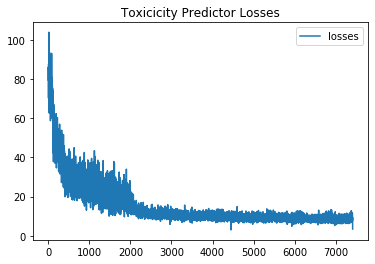

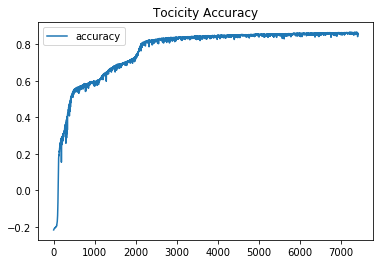

In [79]:
# ------------------------------
#  Toxicicty Predictor Training
# ------------------------------

# Options
losses = []
v_losses = []
acc = []
n_epochs = 5
validate_every = 700

def tox_train():
  loop = tqdm(total=len(tox_dataloader_train) * n_epochs, position=0)
  for epoch in range(n_epochs):

      for i, (peps, toxs) in enumerate(tox_dataloader_train):
          peps = Variable(peps.type(Tensor))
          toxs = Variable(toxs.type(Tensor))
          optimizer_tox.zero_grad()

          y_hat = tox_predictor(peps)

          loss = torch.sum(torch.abs(y_hat.squeeze()-toxs))
          loss.backward()
          losses.append(loss.item())
          optimizer_tox.step()
          last_acc = 0
          if i % validate_every:
            a = []
            for v_peps, v_toxs in tox_dataloader_test:
              v_peps = Variable(v_peps.type(Tensor))
              v_toxs = Variable(v_toxs.type(Tensor))
              v_y_hat = tox_predictor(v_peps)
              a.append(accuracy(v_y_hat.squeeze(), v_toxs).item())
            last_acc = np.mean(a)
            acc.append((len(losses), last_acc))

          loop.set_description("Epoch {}, Batch {}, Toxic_Loss {:.4f}, Accuracy {:.4f}".format(epoch, i, loss.item(), last_acc))
          loop.update()

# No need to retrain if we can just load the network from a file
tox_train()

# Plot accuracy and loss
plt.plot(losses, label='losses')
plt.title('Toxicicity Predictor Losses')
plt.legend()
plt.show()

a, b = zip(*acc)
plt.plot(a, b, label='accuracy')
plt.title('Tocicity Accuracy')
plt.legend()
plt.show()

In [103]:
# --------------------------
#  Optimize a toxic peptide
# --------------------------
batch = 5

# z = torch.Tensor(np.random.random(size=(batch, 1, 8, 12)))
z = torch.Tensor(np.random.random(size=(batch, wgan_opt.latent_dim)))
z = z.cuda()

optim = torch.optim.Adam([z.requires_grad_()], lr=0.0001)

epochs = 100000
loop = tqdm(total=epochs, position=0)

for epoch in range(epochs):
    optim.zero_grad()
    
    # pep = t_net(z)
    pep = generator(z)

    loss = torch.mean(tox_predictor(pep)) * 10000000

    loss.backward()

    optim.step()

    z.data.clamp_(-3, 3)

    loop.set_description("Epoch {}/{} Loss {:.4f}".format(epoch+1, epochs, loss.item()))
    loop.update()

peps = decode_peptide_s(pep.squeeze(1))
one_peps = one_hot_s(peps).unsqueeze(1)
one_peps = one_peps.cuda()
toxes = tox_predictor(one_peps)

for i, tox in enumerate(toxes):
  # if tox < 0:
    print("Final Output: {} {:.6f}".format(peps[i], tox.item()))

Epoch 19060/100000 Loss 2476887.0000:  19%|█▉        | 19059/100000 [01:57<08:27, 159.42it/s]

KeyboardInterrupt: ignored

In [104]:
peps = decode_peptide_s(pep.squeeze(1))
one_peps = one_hot_s(peps).unsqueeze(1)
one_peps = one_peps.cuda()
toxes = tox_predictor(one_peps)

for i, tox in enumerate(toxes):
  # if tox < 0:
    print("Final Output: {} {:.6f}".format(peps[i], tox.item()))

Final Output: FDFGVCGG -0.173559
Final Output: ILVFLFFD 2.036880
Final Output: HCFCVNNF -0.307703
Final Output: SNGVFHHV 0.137907
Final Output: FFCCGYSY -0.423607


In [102]:
pep[0]

tensor([[3.8128e-05, 2.8095e-38, 1.7601e-25, 1.0168e-21, 1.8329e-42, 0.0000e+00,
         9.9996e-01, 7.4871e-42, 1.5522e-27, 0.0000e+00, 3.3837e-21, 0.0000e+00],
        [1.0000e+00, 2.4549e-39, 4.4753e-13, 4.8412e-19, 3.5979e-22, 0.0000e+00,
         5.9885e-33, 1.2297e-37, 0.0000e+00, 0.0000e+00, 5.7007e-22, 0.0000e+00],
        [2.4161e-10, 7.3152e-04, 9.2720e-40, 6.6184e-36, 2.2421e-27, 0.0000e+00,
         9.9927e-01, 1.0059e-10, 0.0000e+00, 1.2913e-16, 1.4013e-45, 2.2353e-32],
        [1.7111e-22, 0.0000e+00, 1.3060e-08, 1.0214e-30, 0.0000e+00, 9.9956e-01,
         2.5225e-36, 4.3704e-04, 4.0638e-44, 2.2201e-08, 7.9674e-12, 0.0000e+00],
        [5.6714e-32, 1.4166e-37, 4.2173e-35, 5.0470e-19, 0.0000e+00, 1.2636e-28,
         0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 6.0846e-20, 0.0000e+00],
        [2.5347e-24, 1.8239e-09, 0.0000e+00, 1.0000e+00, 3.6474e-38, 8.3048e-30,
         8.9254e-28, 5.2291e-24, 2.9668e-32, 4.9186e-43, 0.0000e+00, 0.0000e+00],
        [5.2038e-12, 9

# Tests and junk

In [0]:
class TranslateNet(nn.Module):
  def __init__(self):
    super(TranslateNet, self).__init__()

    self.net = nn.Sequential(
        nn.Conv2d(1, 32, kernel_size=(1, 3), padding=(0, 1)),
        nn.ReLU(),
        nn.Conv2d(32, 32, kernel_size=(1, 3), padding=(0, 1)),
        nn.ReLU(),
        nn.Conv2d(32, 32, kernel_size=(1, 3), padding=(0, 1)),
        nn.ReLU(),
        nn.Conv2d(32, 32, kernel_size=(1, 3), padding=(0, 1)),
        nn.ReLU(),
        nn.Conv2d(32, 32, kernel_size=(1, 3), padding=(0, 1)),
        nn.ReLU(),
        nn.Conv2d(32, 32, kernel_size=(1, 3), padding=(0, 1)),
        nn.ReLU(),
        nn.Conv2d(32, 32, kernel_size=(1, 3), padding=(0, 1)),
        nn.ReLU(),
        nn.Conv2d(32, 1, kernel_size=(1, 3), padding=(0, 1)),
    )
  
  def forward(self, x):
    ret = self.net(x)
    return F.softmax(ret, dim=3)

# Define the t_net
t_net = TranslateNet()
t_net = t_net.cuda()


In [10]:
print_every = 100
rounds = 500*print_every
batch_size = 64

# Define the optimizer
t_optim = torch.optim.Adam(t_net.parameters(), lr=0.0001)

for r in range(rounds):
  if r == 8000:
    t_optim.lr = 0.00001
    print("Adjusting Learning Rate...")

  x = Variable(Tensor(np.random.random(size=(batch_size,8*12))))
  x = x.view(batch_size, 8, -1)
  y_truth = F.one_hot(torch.argmax(x, dim=2), 12)

  x = x.unsqueeze(1)
  y_truth = y_truth.unsqueeze(1)

  t_optim.zero_grad()

  y_hat = t_net(x)
  # loss = torch.sum((y_hat - y_truth)*(y_hat - y_truth))
  loss = torch.max(torch.max(torch.abs(y_hat-y_truth), dim=3)[0])

  loss.backward()

  t_optim.step()

  if r%print_every == 0:
    print("{}/{} loss: {:.4f}".format(r+1, rounds, loss.item()))


1/50000 loss: 0.6769
101/50000 loss: 0.7085
201/50000 loss: 0.6848
301/50000 loss: 0.6944
401/50000 loss: 0.6562
501/50000 loss: 0.7155
601/50000 loss: 0.6701
701/50000 loss: 0.7113
801/50000 loss: 0.7030
901/50000 loss: 0.6513
1001/50000 loss: 0.6814
1101/50000 loss: 0.7390
1201/50000 loss: 0.7033
1301/50000 loss: 0.6620
1401/50000 loss: 0.7345
1501/50000 loss: 0.6875
1601/50000 loss: 0.6900
1701/50000 loss: 0.6732
1801/50000 loss: 0.6616
1901/50000 loss: 0.6688
2001/50000 loss: 0.6876
2101/50000 loss: 0.6983
2201/50000 loss: 0.7143
2301/50000 loss: 0.7167
2401/50000 loss: 0.7330
2501/50000 loss: 0.6286
2601/50000 loss: 0.7142
2701/50000 loss: 0.6898
2801/50000 loss: 0.6962
2901/50000 loss: 0.6818
3001/50000 loss: 0.7195
3101/50000 loss: 0.7321
3201/50000 loss: 0.6895
3301/50000 loss: 0.7637
3401/50000 loss: 0.6226
3501/50000 loss: 0.7214
3601/50000 loss: 0.6643
3701/50000 loss: 0.7292
3801/50000 loss: 0.7230
3901/50000 loss: 0.6673
4001/50000 loss: 0.7105
4101/50000 loss: 0.6851
4201

KeyboardInterrupt: ignored

In [14]:
test = torch.Tensor(np.random.random(size=(5, 1, 8,12)))

# print(torch.argmax(test, dim=2))
test = test.cuda()
peps = t_net(test)
# print(torch.argmax(peps, dim=2))
for i, pep in enumerate(peps):
  print("{}\n{}\n\n".format(decode_peptide(pep.squeeze()), decode_peptide(test[i].squeeze())))


VNYRCDGI
VNYRCDGI


HGNLYLSL
DGNLYLSL


GIFSVCDY
CIFSVCDY


DRLGHLHV
DRLGHLHV


VGYRLNSS
VGYRLNSS




In [34]:
# -------------------------------------
#  Optimize towards a specific peptide
# -------------------------------------

dataset = GenericDataloader(one_hot_s(np.load("All_Peptide_Sequences.npy")), np.load("All_Peptide_Scores_Punished.npy"), train="all")

# Holder of all the z-vectors
peptide_z_vector = []

loss_func = nn.L1Loss()

target, _ = dataset[:1]
target_pep = decode_peptide(target[0])
target = target.unsqueeze(0)
target = target.cuda()

z = torch.Tensor(np.random.random(size=(1, 1, 8, 12)))
z = z.cuda()

optim = torch.optim.Adam([z.requires_grad_()], lr=0.1)

print_every = 500
epochs = 10000

for epoch in range(epochs):
    optim.zero_grad()
    
    pep = t_net(z)

    loss = tox_predictor(pep)

    # loss = torch.sum(torch.abs(pep - target))
    loss.backward()

    optim.step()
    if epoch%print_every == 0:
      print("{} {:.6f}".format(decode_peptide(pep[0][0]), loss.item()))

pep_name = decode_peptide(pep[0][0])
encoded_pep = one_hot(pep_name).unsqueeze(0)
encoded_pep = encoded_pep.cuda()

print("{} {:.6f}".format(pep_name, tox_predictor(encoded_pep).item()))

FLHVVRNV -0.313570
FFCRYFRF -1.931098
FFCIYFRF -1.923435
FFCRYFRF -1.910039
FFCRFFRF -2.270261
FFCRFFRF -2.270038
FFCRFFRF -2.271517
FFCRFFRF -2.271717
FFCRFFRF -2.266730
FFCRFFRF -2.264028
FFCRFFRF -2.271335
FFCRFFRF -2.271784
FFCRFFRF -2.271149
FFCRFFRF -2.271945
FFCRFFRF -2.271731
FFCRFFRF -2.272085
FFCRFFRF -2.271779
FFLRFFRF -2.388973
FFLRFFRF -2.388940
FFLRFFRF -2.388950
FFLRFFRF -2.386034


In [19]:
# -------------------------
# Toxic Peptide classifier
# -------------------------

class ToxicityPredictor(nn.Module):
  def __init__(self):
    super(ToxicityPredictor, self).__init__()

    self.model = nn.Sequential(
        nn.Linear(int(len(wgan_opt.amino_acids) * wgan_opt.peptide_length), 512),
        nn.ReLU(),
        nn.Linear(512, 256),
        nn.ReLU(),
        nn.Linear(256, 256),
        nn.ReLU(),
        nn.Linear(256, 256),
        nn.ReLU(),
        nn.Linear(256, 256),
        nn.ReLU(),
        nn.Linear(256, 256),
        nn.ReLU(),
        nn.Linear(256, 256),
        nn.ReLU(),
        nn.Linear(256, 1),
    )

  def forward(self, pep):
    pep_flat = pep.view(pep.size(0), -1)
    tox = self.model(pep_flat)

    return tox

# Initialize Predictor
tox_predictor = ToxicityPredictor()
tox_predictor.cuda()

ToxicityPredictor(
  (model): Sequential(
    (0): Linear(in_features=96, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=256, bias=True)
    (5): ReLU()
    (6): Linear(in_features=256, out_features=256, bias=True)
    (7): ReLU()
    (8): Linear(in_features=256, out_features=256, bias=True)
    (9): ReLU()
    (10): Linear(in_features=256, out_features=256, bias=True)
    (11): ReLU()
    (12): Linear(in_features=256, out_features=256, bias=True)
    (13): ReLU()
    (14): Linear(in_features=256, out_features=1, bias=True)
  )
)

In [22]:
# ------------------------------
#  Toxicicty Predictor Training
# ------------------------------

load_model(tox_predictor, "tox_classifier.pt")
print("Network Successfully Loaded!")

Network Successfully Loaded!
